In [1]:
# Data visualize를 위한 imports
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
# GPU 한 개만 할당을 위함
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]="0, 1, 2, 3"

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from configparser import Interpolation
from saveLoad import save, load
from sklearn.metrics import confusion_matrix
import seaborn as sn
from util import TwoCropTransform, AverageMeter
from util import adjust_learning_rate, warmup_learning_rate, accuracy
from util import set_optimizer, save_model
from resnet_big import SupConResNet
from losses import SupConLoss
from torchvision.transforms.functional import to_pil_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

pd.set_option('display.max.colwidth', 30)

# 경로 설정하기
original_data_path = '/disk1/colonoscopy_dataset/cropped/' # ADC / HGD / LGD / NOR
base_dir = '/home/sundongk/Self-supervised_contrastive_learning'
data_dir = original_data_path
ckpt_dir = os.path.join(base_dir, "checkpoint")
root_dir = '/home/sundongk/dataset/'
train_path = os.path.join(root_dir, 'train')
valid_path = os.path.join(root_dir, 'valid')
test_path = os.path.join(root_dir, 'test')
checkpoint_path_1 = os.path.join(base_dir, 'chk_loss')
checkpoint_path_2 = os.path.join(base_dir, 'chk_acc')
q_encoder_path = os.path.join(base_dir, 'q_encoder_chk')
k_encoder_path = os.path.join(base_dir, 'k_encoder_chk')

Device: cuda
Current cuda device: 0
Count of using GPUs: 4


# Datasets for training model

In [2]:
batch_size = 128; test_batch_size = 1

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.590, 0.351, 0.259],
                                 std=[0.241, 0.199, 0.163])
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.590, 0.351, 0.259],
                                 std=[0.241, 0.199, 0.163])
    ]),
    'test':
    transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.590, 0.351, 0.259],
                                 std=[0.241, 0.199, 0.163])
    ])
}

class Split:
    def __init__(self, base_transform):
        self.base_transform = base_transform
    
    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]

image_datasets = {
    'train': ImageFolder(root=train_path, transform=Split((data_transforms['train'])), target_transform=None),
    'validation': ImageFolder(root=valid_path, transform=Split(data_transforms['validation']), target_transform=None),
    'test': ImageFolder(root=test_path, transform=Split(data_transforms['test']), target_transform=None),
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=8),
    'validation': DataLoader(image_datasets['validation'], batch_size=batch_size, shuffle=False, num_workers=8),
    'test': DataLoader(image_datasets['test'], batch_size=test_batch_size, shuffle=False, num_workers=8)
}

img size:  torch.Size([3, 224, 224])


(-0.5, 223.5, 223.5, -0.5)

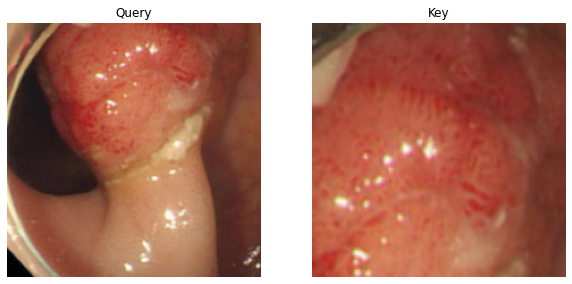

In [3]:
img, label = image_datasets['train'][0]

query, key = img[0], img[1]

print('img size: ', query.shape)

# denormalization query
og = query.cpu().squeeze(0).permute(1,2,0).numpy()
og[:,:,0] = ((og[:,:,0]) * 0.241) + 0.590
og[:,:,1] = ((og[:,:,1]) * 0.199) + 0.351
og[:,:,2] = ((og[:,:,2]) * 0.163) + 0.259
# denormalization key
key = key.cpu().squeeze(0).permute(1,2,0).numpy()
key[:,:,0] = ((key[:,:,0]) * 0.241) + 0.590
key[:,:,1] = ((key[:,:,1]) * 0.199) + 0.351
key[:,:,2] = ((key[:,:,2]) * 0.163) + 0.259

# display query and key
plt.figure(figsize=(10,10)); plt.subplot(1,2,1)
plt.imshow(og)
plt.title('Query'); plt.axis('off'); plt.subplot(1,2,2)
plt.imshow(key)
plt.title('Key'); plt.axis('off')

# Resnet18

- Self-supervised contrastive learning

In [4]:
from torchvision import models
import copy

q_encoder = models.resnet18(pretrained=False)

classifier = nn.Sequential(
                nn.Linear(q_encoder.fc.in_features, 100),
                nn.ReLU(inplace=True), # input 수정, 메모리 효율 up
                nn.Linear(100, 50),
                nn.ReLU(inplace=True),
                nn.Linear(50, 25)).to(device)
                
q_encoder.fc = classifier
k_encoder = copy.deepcopy(q_encoder)

if torch.cuda.is_available():
    if torch.cuda.device_count() > 1:
        q_encoder = torch.nn.DataParallel(q_encoder)

    q_encoder = q_encoder.cuda()
    k_encoder = k_encoder.cuda()    

/home/sundongk/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sundongk/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
from torchsummary import summary
summary(q_encoder, (3, 256, 256), device = device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

# Contrastive loss

In [6]:
# loss function
def loss_func(q, k, queue, t = 0.05):
    # t : temperature
    N = q.shape[0] # batch_size
    C = q.shape[1] # channel

    # bmm: batch matrix multiplication
    pos = torch.exp(torch.div(torch.bmm(q.view(N,1,C), k.view(N,C,1)).view(N,1),t))
    neg = torch.sum(torch.exp(torch.div(torch.mm(q.view(N,C),torch.t(queue)),t)),dim=1)

    # denominator is sum over pos and neg
    denominator = pos + neg

    return torch.mean(-torch.log(torch.div(pos,denominator)))

# Negative samples

In [7]:
# initialize the queue
queue = None
K = 8192 # K: number of negatives to store in queue

# fill the queue with negative samples
flag = 0
if queue is None:
    while True:
        with torch.no_grad():
            for img, _ in dataloaders['train']:
                # extract key samples
                xk = img[1].to(device)
                k = k_encoder(xk).detach()

                if queue is None:
                    queue = k
                else:
                    if queue.shape[0] < K: # queue < 8192
                        queue = torch.cat((queue,k),0)
                    else:
                        flag = 1 # stop filling the queue

                if flag == 1:
                    break 

        if flag == 1:
            break

queue = queue[:K]

In [10]:
# Sanity check
print('number of negative samples in queue : ',len(queue))

number of negative samples in queue :  8192


In [11]:
import time

optimizer = optim.Adam(q_encoder.parameters())
train_loss = []; val_loss = []

# define function to training
def train_model(q_encoder, k_encoder, num_epochs=1, st_epoch=0, queue=queue, sanity_check=False):
    momentum = 0.999
    start_time = time.time()
    q_encoder.train()
    
    best_loss = 1e10; best_train_loss = 1e10
    for epoch in range(st_epoch+1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs)); print('-' * 10)
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            running_loss = .0

            if phase == 'train': 
                q_encoder.train()   # Set query encoder to training mode
            else:                
                q_encoder.eval()    # Set query encoder to evaluate mode
            
            # Epoch
            for batch, (images, labels) in enumerate(dataloaders[phase], 1):
                if batch % 10 == 0:
                    print('{}/{}'.format(batch, len(dataloaders[phase])))
                
                # retrieve query and key
                xq = images[0].to(device)
                xk = images[1].to(device)
                
                k = k_encoder(xk).detach()
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase=='train'):
                    # get model ouputs
                    q = q_encoder(xq)
                    # normalize representations
                    q = torch.div(q, torch.norm(q, dim=1).reshape(-1, 1))
                    k = torch.div(k, torch.norm(k, dim=1).reshape(-1, 1))
                    # get loss value
                    loss = loss_func(q, k , queue)

                if phase == 'train': 
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss

                # update the queue
                queue = torch.cat((queue, k), 0)

                if queue.shape[0] > K:
                    queue = queue[256:, :]
                
                # update k_encoder
                for q_params, k_params in zip(q_encoder.parameters(), k_encoder.parameters()):
                    k_params.data.copy_(momentum*k_params + q_params*(1.0-momentum))
                    
            epoch_loss = running_loss / len(image_datasets[phase])
            print('{} loss: {:.4f}'.format(phase, epoch_loss))
            
            if phase == 'train':
                train_loss.append(epoch_loss)    
                if epoch % 50 == 0:
                    print(f"saving epoch {epoch}'s train model to {checkpoint_path_1}")
                    save(ckpt_dir=q_encoder_path, model=q_encoder, optim=optimizer, epoch=epoch)
                    save(ckpt_dir=k_encoder_path, model=k_encoder, optim=optimizer, epoch=epoch)
            else:
                val_loss.append(epoch_loss)
                if epoch_loss < best_loss:
                    print(f"saving best loss model to {checkpoint_path_1}")
                    best_loss = epoch_loss
                    save(ckpt_dir=q_encoder_path, model=q_encoder, optim=optimizer, epoch=epoch)
                    save(ckpt_dir=k_encoder_path, model=k_encoder, optim=optimizer, epoch=epoch)

    return q_encoder, k_encoder

In [12]:
q_encoder, optimizer, qst_epoch = load(ckpt_dir=q_encoder_path, model=q_encoder, optim=optimizer)
k_encoder, optimizer, kst_epoch = load(ckpt_dir=k_encoder_path, model=k_encoder, optim=optimizer)

print(qst_epoch, kst_epoch)

489 489


In [ ]:
q_encoder, k_encoder = train_model(q_encoder, k_encoder, num_epochs=500, st_epoch=qst_epoch)

# Representation vector T-SNE visualization

/home/sundongk/miniconda3/envs/test/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sundongk/miniconda3/envs/test/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/sundongk/miniconda3/envs/test/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


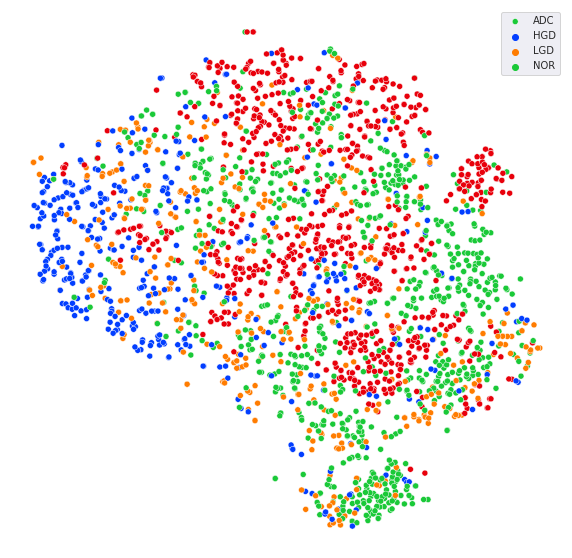

In [41]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

def plot_vecs_n_labels(v, labels, fname):
    fig = plt.figure(figsize = (10,10))
    plt.axis('off')
    sn.set_style('darkgrid')
    sn.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sn.color_palette("bright", 4))
    plt.legend(['ADC', 'HGD', 'LGD', 'NOR'])
    plt.savefig(fname)

dataloaders['train'] = DataLoader(image_datasets['train'], 3000, True)

for x,y in dataloaders['train']:
    x = x.to(device)
    with torch.no_grad():
        pred = q_encoder(x)
    pred_tsne = tsne.fit_transform(pred.cpu().data)
    plot_vecs_n_labels(pred_tsne, y, 'tsen.png')
    break

# Classifier 학습을 위한 Dataset

In [13]:
batch_size = 128; test_batch_size = 1

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.590, 0.351, 0.259],
                                 std=[0.241, 0.199, 0.163])
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.590, 0.351, 0.259],
                                 std=[0.241, 0.199, 0.163])
    ]),
    'test':
    transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.590, 0.351, 0.259],
                                 std=[0.241, 0.199, 0.163])
    ])
}

image_datasets = {
    'train': ImageFolder(root=train_path, transform=data_transforms['train'], target_transform=None),
    'validation': ImageFolder(root=valid_path, transform=data_transforms['validation'], target_transform=None),
    'test': ImageFolder(root=test_path, transform=data_transforms['test'], target_transform=None),
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=8),
    'validation': DataLoader(image_datasets['validation'], batch_size=batch_size, shuffle=False, num_workers=8),
    'test': DataLoader(image_datasets['test'], batch_size=test_batch_size, shuffle=False, num_workers=8)
}

# Pretained model + Classifier

In [14]:
# Removing the projection head of q_encoder 
if len(nn.Sequential(*list(q_encoder.module.fc.children()))) == 5:
    q_encoder.module.fc = nn.Sequential(*list(q_encoder.module.fc.children())[:-3])

In [15]:
print(*list(q_encoder.module.fc))

Linear(in_features=512, out_features=100, bias=True) ReLU(inplace=True)


In [16]:
# define Linear Classifier for transfer learning
class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(100,4)

    def forward(self, x):
        x = self.fc1(x)
        return x

linear_classifier = LinearClassifier().to(device)

# Classifier 학습

In [17]:
classifier_chk_path = os.path.join(base_dir, 'classifier_chk_path')

import time

# training LinearClassifier
linear_loss_func = nn.CrossEntropyLoss()
linear_opt = optim.SGD(linear_classifier.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-6)
train_loss = []; val_loss = []

# define function to training
def train_classifier(num_epochs=1, st_epoch=0):
    momentum = 0.999
    start_time = time.time()
    q_encoder.train()
    
    best_loss = 1e10; best_train_loss = 1e10
    for epoch in range(st_epoch+1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs)); print('-' * 10)
        since = time.time()
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            running_loss = 0; running_metric = 0

            if phase == 'train': 
                linear_classifier.train()   # Set query encoder to training mode
            else:                
                linear_classifier.eval()    # Set query encoder to evaluate mode
            
            # Epoch
            for batch, (images, labels) in enumerate(dataloaders[phase], 1):
                if batch % 10 == 0:
                    print('{}/{}'.format(batch, len(dataloaders[phase])))
                
                input = images.to(device)
                label = labels.to(device)

                with torch.no_grad():
                    output_encoder = q_encoder(input)
                
                linear_opt.zero_grad()
                pred = linear_classifier(output_encoder)
                loss = linear_loss_func(pred, label)
                running_loss += loss

                if phase == 'train':                    
                    loss.backward()
                    linear_opt.step()      
                    
            
                pred = pred.argmax(1, keepdim=True)
                metric = pred.eq(label.view_as(pred)).sum().item()
                running_metric += metric

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_metric = running_metric / len(image_datasets[phase])

            if phase == 'train':
                train_loss.append(epoch_loss)
                print('{} loss: {:.4f}, acc: {:.4f}'.format(phase, epoch_loss, epoch_metric))
            else:
                val_loss.append(epoch_loss)
                print('{} loss: {:.4f}, acc: {:.4f}'.format(phase, epoch_loss, epoch_metric))
                if epoch_loss < best_loss:
                    print(f"saving best loss model to {classifier_chk_path}")
                    best_loss = epoch_loss
                    save(ckpt_dir=classifier_chk_path, model=linear_classifier, optim=optimizer, epoch=epoch)

    return linear_classifier

In [33]:
trained_classifier = train_classifier(num_epochs=500)

Epoch 1/500
----------
10/19
train loss: 0.0429
validation loss: 0.0883, acc: 0.4267
saving best loss model to /home/sundongk/Self-supervised_contrastive_learning/classifier_chk_path
Epoch 2/500
----------
10/19
train loss: 0.0398
validation loss: 0.1012, acc: 0.3733
Epoch 3/500
----------
10/19
train loss: 0.0285
validation loss: 0.0833, acc: 0.3633
saving best loss model to /home/sundongk/Self-supervised_contrastive_learning/classifier_chk_path
Epoch 4/500
----------
10/19
train loss: 0.0371
validation loss: 0.1559, acc: 0.2700
Epoch 5/500
----------
10/19
train loss: 0.0478
validation loss: 0.1616, acc: 0.3067
Epoch 6/500
----------
10/19
train loss: 0.0361
validation loss: 0.1222, acc: 0.3533
Epoch 7/500
----------
10/19
train loss: 0.0328
validation loss: 0.0944, acc: 0.4033
Epoch 8/500
----------
10/19
train loss: 0.0274
validation loss: 0.0649, acc: 0.4433
saving best loss model to /home/sundongk/Self-supervised_contrastive_learning/classifier_chk_path
Epoch 9/500
----------
10/

KeyboardInterrupt: 

In [43]:
trained_classifier, optimizer, qst_epoch = load(ckpt_dir=classifier_chk_path, model=linear_classifier, optim=optimizer)
print(qst_epoch)

28


# T-SNE 시각화

301


/home/sundongk/miniconda3/envs/test/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sundongk/miniconda3/envs/test/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/sundongk/miniconda3/envs/test/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


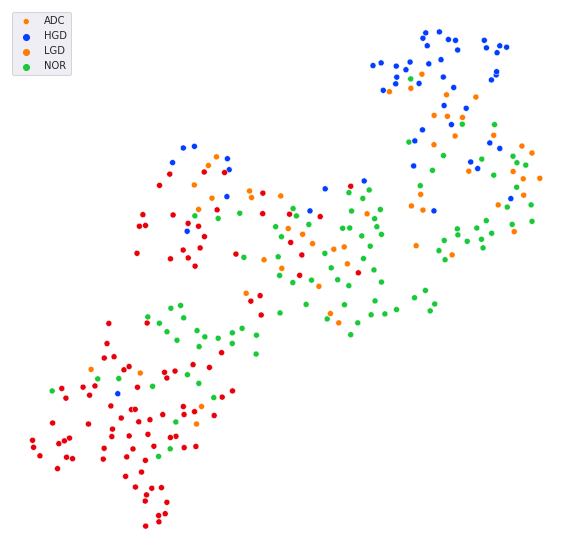

: 

In [47]:
from sklearn.manifold import TSNE

tsne = TSNE()

def plot_vecs_n_labels(v, labels, fname):
    fig = plt.figure(figsize = (10,10))
    plt.axis('off')
    sn.set_style('darkgrid')
    sn.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sn.color_palette("bright", 4))
    plt.legend(['ADC', 'HGD', 'LGD', 'NOR'])
    plt.savefig(fname)

dataloaders['train'] = DataLoader(image_datasets['train'], 3000, True)
dataloaders['validation'] = DataLoader(image_datasets['validation'], 3000, True)
dataloaders['test'] = DataLoader(image_datasets['test'], 3000, True)

for x,y in dataloaders['test']:
    print(len(x))
    x = x.to(device)
    with torch.no_grad():
        pred = q_encoder(x)
        pred = linear_classifier(pred)
    pred_tsne = tsne.fit_transform(pred.cpu().data)
    plot_vecs_n_labels(pred_tsne, y, 'tsen.png')
    break

## Loss 및 Accuracy 저장

In [34]:
import pickle
# loss 및 acc 정보 저장
loss_dict = {}
loss_dict['train_loss'] = train_loss; loss_dict['val_loss'] = val_loss

# loss_dict 저장
with open('data_dict.pkl','wb') as f:
    pickle.dump(loss_dict,f)

# 시각화 및 평가

In [38]:
import pickle
# loss_dict 불러오기
loss_info_path = '/home/sundongk/Self-supervised_contrastive_learning/data_dict.pkl'
with open(loss_info_path,'rb') as f:
    mydict = pickle.load(f)

train_loss = mydict['train_loss']; #train_acc = mydict['train_acc']
val_loss = mydict['val_loss']; #val_acc = mydict['val_acc']

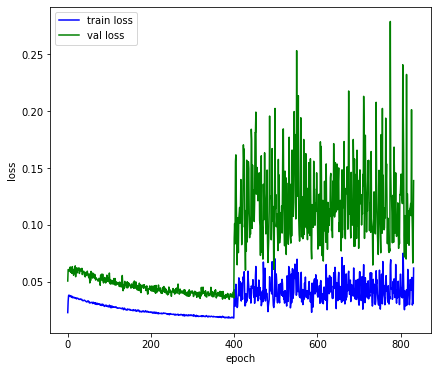

In [39]:
# Loss 시각화
_tloss = np.asarray([]); _vloss = np.asarray([])
for i in train_loss:
    _tloss = np.append(_tloss, i.detach().cpu().numpy())
for i in val_loss:
    _vloss = np.append(_vloss, i.detach().cpu().numpy())


plt.figure(figsize=(15, 6)) 
plt.subplot(1,2,1)
plt.ylabel('loss'); plt.xlabel('epoch')
plt.plot(_tloss, 'b', label='train loss')
plt.plot(_vloss, 'g', label='val loss')
plt.legend(loc='best')
plt.show()

NameError: name 'train_acc' is not defined

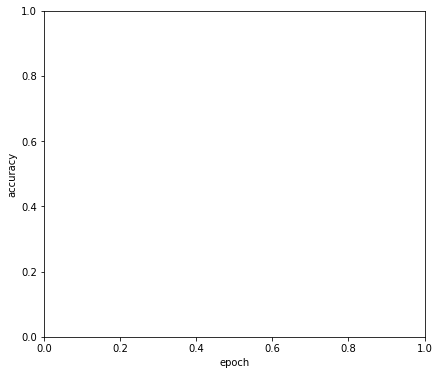

In [37]:
# Acc 시각화
plt.figure(figsize=(15, 6)) 
plt.subplot(1,2,1)
plt.ylabel('accuracy'); plt.xlabel('epoch')
plt.plot(train_acc, 'b', label='train acc')
plt.plot(val_acc, 'g', label='val acc')
plt.legend(loc='best')
plt.show()

In [ ]:
plt.show(); plt.close('all'); plt.clf()
model, optimizer, st_epoch = load(ckpt_dir=checkpoint_path_1, model=model, optim=optimizer)
print(st_epoch)

# Test 데이터셋에 대한 결과

In [ ]:
# Inference
total = correct = 0

model.eval()
with torch.no_grad():
    running_corrects = 0
    
    for batch, item in enumerate(dataloaders['test'], 1):
        inputs = item['input'].to(device)
        labels = item['label'].to(device)

        outputs = model(inputs)

        probs = nn.Softmax(dim=1)(outputs)
        predicts = torch.argmax(outputs, dim=1)

        total += len(labels)
        correct += (predicts == labels).sum().item()
        # print(probs, predicts, labels)
        # # 불러온 이미지 시각화
        # plt.figure(figsize=(12,12))
        # input_image_example = plt.subplot(1,3,1)
        # input_image_example.set_title(f'ADC: {100*pred_probs[0][3]:.2f}, HGD: {100*pred_probs[0][2]:.2f}, LGD: {100*pred_probs[0][1]:.2f}, NOR: {100*pred_probs[0][0]:.2f}')

        # plt.imshow(to_pil_image(changeTensor(inputs)))
        # print(outputs, labels, pred_probs)
        # print(f'NOR: {100*pred_probs[0][0]:.2f}, LGD: {100*pred_probs[0][1]:.2f}, HGD: {100*pred_probs[0][2]:.2f}, ADC: {100*pred_probs[0][3]:.2f}, ')
        # plt.show()
        # plt.close('all')
        # plt.clf()
    print('Test Accuracy of the model on the {} test images: {}%'.format(total, 100 * correct / total))

        

In [ ]:
print(model)

# Confusion matrix

In [ ]:
# ADC: 51, HGD:50, LGD:100, NOR:100
y_pred = []
y_true = []

# Inference
model.eval()
with torch.no_grad():
    for batch, item in enumerate(dataloaders['test'], 1):
        inputs = item['input'].to(device)
        labels = item['label'].to(device)

        outputs = model(inputs)
        outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        y_pred.extend(outputs) # save prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # save ground truth

class_names = ('ADC', 'HGD', 'LGD', 'NOR')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

sn.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
plt.title("Confusion Matrix"), plt.tight_layout()
 
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from pprint import pprint as pp

pp(classification_report(y_true, y_pred))

# Grad-CAM

In [ ]:
import cv2 

class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x


class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """

    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        #print(x.shape)
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)
        
        return target_activations, x


def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img.requires_grad_(True)
    return input


def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    os.path.join(base_dir, "cam.jpg")
    #cv2.imwrite("cam.jpg", np.uint8(255 * cam))
    cv2.imwrite(os.path.join(base_dir, "cam.jpg"), np.uint8(255 * cam))

class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            features, output = self.extractor(input.cuda())#[1, 2048, 7, 7], [1, 1000]
        else:
            features, output = self.extractor(input)


        if index == None:
            index = np.argmax(output.cpu().data.numpy())
        #print(index)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)#1,1000
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
            print(one_hot)
        else:
            one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()#1, 2048, 7, 7
        target = features[-1]#1,2048,7,7
        target = target.cpu().data.numpy()[0, :]#2048, 7, 7

        weights = np.mean(grads_val, axis=(2, 3))[0, :]#2048
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):#w:weight,target:feature
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)#7,7
        cam = cv2.resize(cam, input.shape[2:])#224,224
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

In [ ]:
# ADC_img_path = '/disk1/colonoscopy_dataset/cropped/ADC/'
# ADC_file_list = os.listdir(ADC_img_path) # ADC 전체 파일 목록
# ADC_data_list = sorted([x for x in ADC_file_list if 'IMG' in x])        # ADC data 파일 목록

grad_cam = GradCam(model=model, feature_module=model.layer4, target_layer_names=["2"], use_cuda=True)
# Inference
total = correct = 0
model.eval()

#with torch.no_grad():
running_corrects = 0
for item in ADC_data_list:
    path = os.path.join(ADC_img_path, item)
    img = cv2.imread(path, 1)
    img = np.float32(cv2.resize(img, (256, 256))) / 255
    input = preprocess_image(img)
    
    target_index = None
    mask = grad_cam(input, target_index)

    cam = show_cam_on_image(img, mask)